# Viral Video Classification
Unsupervised classification task using date, number of views, and other video metadata to assign viral video status.

## Task
A fictitious company VideoTech is an ad-supported online video website, just like YouTube. The CEO has noticed that the homepage of the website has a high bounce rate compared to competitors. When visitors come to the homepage, many leave without watching a video or clicking on ads.

The company spends millions to acquire users but due to the high bounce rate the ROI of those acquisition efforts is low. Currently, the videos shown on the homepage are chosen manually. The CEO thinks that by creating a recommended video section on the homepage, user engagement will go up and bounce rate will go down.

The CEO asks you to come up with a definition for a viral video, videos with view counts that are trending up. The heuristic you choose will be used to choose videos to show in the recommended video section of the homepage. Use the data provided to determine how to classify a video as a viral video.

## Data

The data set available contains 2 tables -

**`video_count`**
- `video_id`: the unique identifier of a video on the website
- `count`: the number of views for a video in a day
- `date`: the day the video was seen

**`video_features`**
- `video_id`: the unique identifier of a video on the website
- `video_length`: length of the video in seconds
- `video_language`: language of the video, as selected by the user when uploaded
- `video_upload_date`: when the video was uploaded
- `video_quality`: quality of the video. One of [240p, 360p, 480p, 720p, 1080p]

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load Data Files and Inspect

### video_count 

In [2]:
#Read csv file
counts = pd.read_csv('video_count.csv')

#Convert date column to datetime type
counts['date'] = pd.to_datetime(counts['date'])

counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41775 entries, 0 to 41774
Data columns (total 3 columns):
video_id    41775 non-null int64
count       41775 non-null int64
date        41775 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 979.2 KB


In [3]:
counts.sort_values(by='date', inplace=True)
counts.head()

,video_id,count,date
18227,2576,1126807,2015-01-01
21967,492,1031016,2015-01-01
5581,2005,271,2015-01-01
5583,50,351,2015-01-01
21972,1606,458361,2015-01-01


In [4]:
counts.date.value_counts()

2015-01-10    2785
2015-01-03    2785
2015-01-09    2785
2015-01-02    2785
2015-01-15    2785
2015-01-08    2785
2015-01-01    2785
2015-01-14    2785
2015-01-07    2785
2015-01-13    2785
2015-01-06    2785
2015-01-12    2785
2015-01-05    2785
2015-01-11    2785
2015-01-04    2785
Name: date, dtype: int64

The data only covers 15 days of video views in 2015. This limits things quite a bit. Also of note is that the videos were all uploaded in the month prior.

### video_features

In [5]:
features = pd.read_csv('video_features.csv')
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2785 entries, 0 to 2784
Data columns (total 5 columns):
video_id             2785 non-null int64
video_length         2785 non-null int64
video_language       2785 non-null object
video_upload_date    2785 non-null object
video_quality        2785 non-null object
dtypes: int64(2), object(3)
memory usage: 108.9+ KB


In [6]:
#Set video ID as the index as it is the unique identifier in this table
features.set_index('video_id', inplace=True)
features.head()

,video_length,video_language,video_upload_date,video_quality
video_id,,,,
2374,1760,Cn,2014-12-06,480p
1897,489,Cn,2014-12-10,720p
2386,1273,Es,2014-12-05,480p
2912,986,Es,2014-12-10,240p
2432,1050,Other,2014-12-10,480p


# Initial inspection of the data
* There are 2785 videos in the dataset.
* The data only covers 15 days of video views in 2015 (a short period of time). 
* The videos were all uploaded in the month prior.
* Over 1000 of the videos show an increase in viewership (even if miniscule).

# Look at some plots of video views

In [7]:
#video ids to plot
videos_to_plot = [1, 1193, 1219, 1472, 2947]

In [66]:
#Function to plot video views over time for a list of video IDs passed in
def plot_video_trends(list_of_vid_ids, legend=True, figsize=(15,6)):
    v_id = list_of_vid_ids.pop(0)
    ax = counts[counts.video_id==v_id].plot(x='date',y='count',label=v_id, legend=legend, figsize=figsize)
    for v_id in list_of_vid_ids:
        ax = counts[counts.video_id==v_id].plot(x='date',y='count',label=v_id, ax=ax, legend=legend)
    ax.set_ylabel('# Views')
    ax.set_xlabel('Date')
    ax.set_title('Video views')
    #ymin, ymax = ax.get_ylim()
    #ax.set_ylim([ymin,6000000])

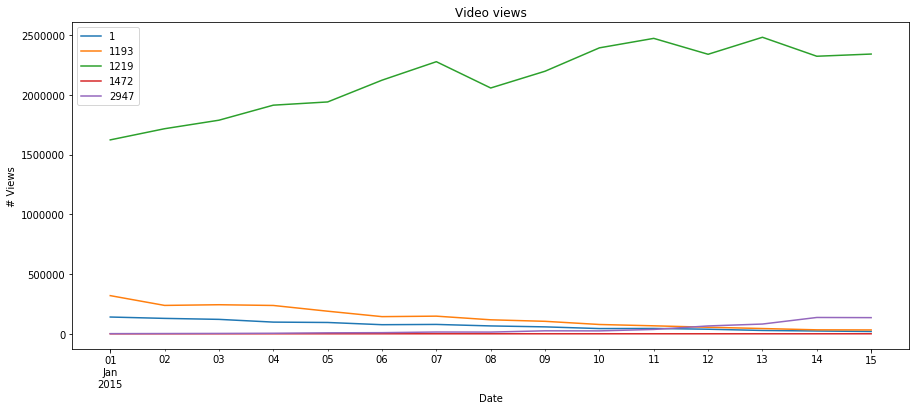

In [9]:
plot_video_trends(videos_to_plot)

# Get total views over entire 15 day period
Merge with features dataframe for further insight regarding video metadata

In [10]:
#Sum views for each video ID.
total_views = counts.groupby('video_id').sum().sort_values(by='count',ascending=False)

#Merge with features table
total_views_merged = features.merge(total_views, left_index=True, right_index=True).sort_values(by='count',ascending=False)

#View top 10 videos by view count
total_views_merged.head(10)

,video_length,video_language,video_upload_date,video_quality,count
video_id,,,,,
692,627,Other,2014-12-14,480p,63178982
2905,420,En,2014-12-16,1080p,63165709
1481,683,De,2014-12-12,720p,60637382
1480,482,Cn,2014-12-16,1080p,59879519
2688,680,En,2014-12-17,360p,57862803
1284,316,Cn,2014-12-17,1080p,57635939
275,185,Cn,2014-12-16,1080p,57549865
1822,377,En,2014-12-09,720p,57276388
2225,497,Es,2014-12-13,360p,56956069


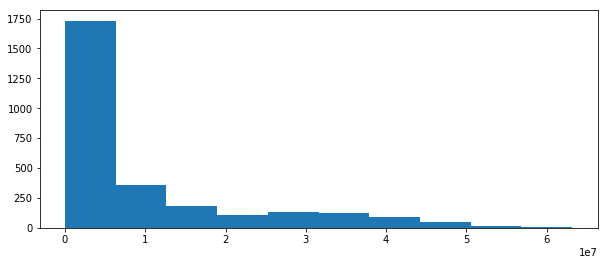

In [11]:
plt.figure(figsize=(10,4))
plt.hist(total_views_merged['count']);

# See view trendlines for all videos

Initial view of trendlines for all videos in the dataset reveals that there are many videos with gradual increases/decreases in view counts; however, there are a handfull of videos with visible trendlines growing at a faster rate than the others. Those videos appear to have more rapid growth in the last ~5 days of the data range.

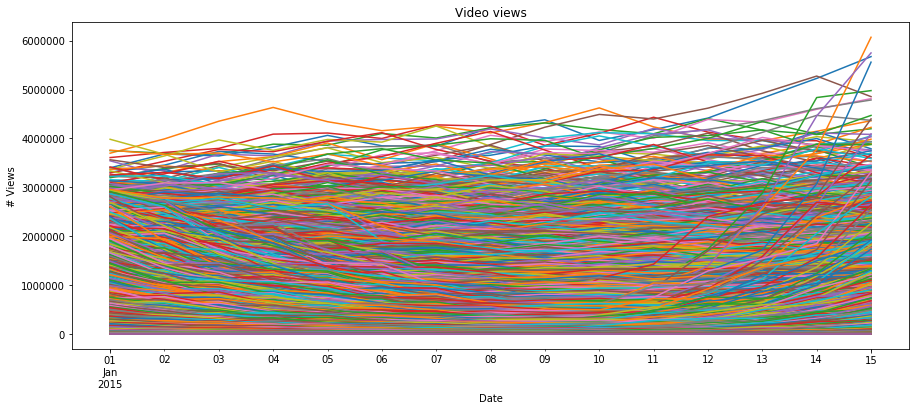

In [12]:
#ALL VIDEOS
plot_video_trends(list(total_views_merged.index.values), legend=False)

### View each Quartile

In [13]:
number_of_vids = len(total_views_merged)
quartile_size = int(number_of_vids/4)

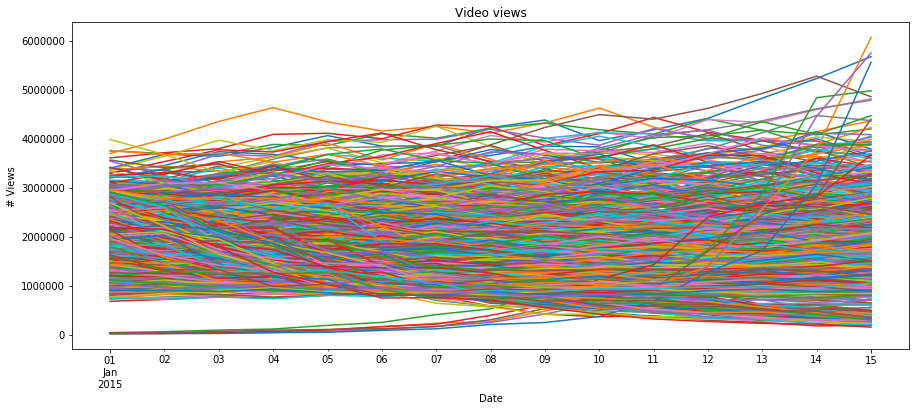

In [14]:
#Top Quartile
plot_video_trends(list(total_views_merged.head(quartile_size).index.values), legend=False)

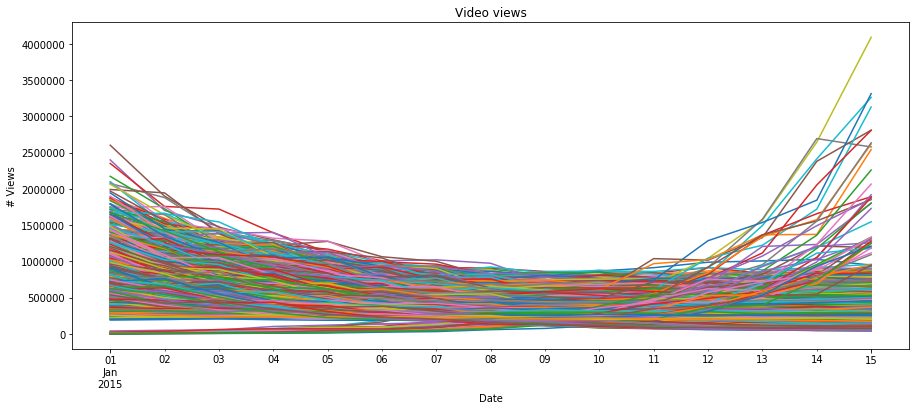

In [15]:
#Q1 - Q2
plot_video_trends(list(total_views_merged.iloc[quartile_size:2*quartile_size].index.values), legend=False)

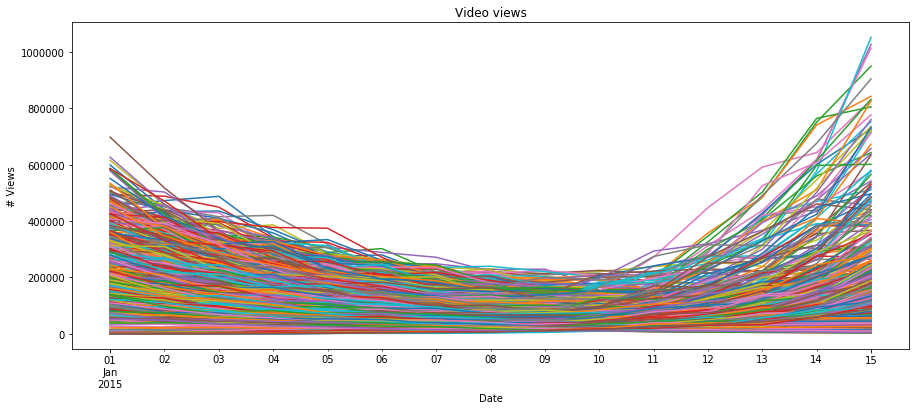

In [16]:
#Q2 - Q3
plot_video_trends(list(total_views_merged.iloc[2*quartile_size:3*quartile_size].index.values), legend=False)

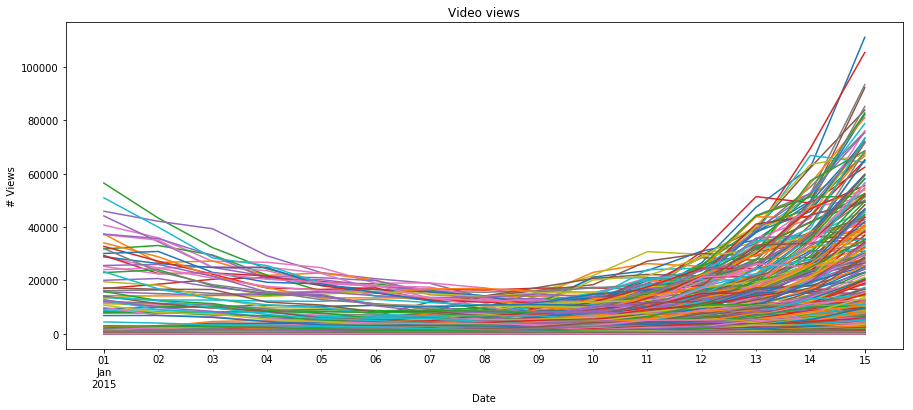

In [17]:
#Bottom Quartile
plot_video_trends(list(total_views_merged.iloc[3*quartile_size:].index.values), legend=False)

### Get OLS slope for video

In [18]:
def get_slope(vid_id, start_day=0, end_day=15):
    y = counts[counts.video_id==vid_id]['count'][start_day:end_day]
    X = range(start_day,end_day)
    X = sm.add_constant(X)
    model = sm.OLS(y,X)
    results = model.fit()
    return results.params['x1']

In [19]:
#15 day slope
video_slopes = []
for v_id in total_views_merged.index.values:
    video_slopes.append(get_slope(v_id))
    
total_views_merged['slope_15_day'] = video_slopes

In [20]:
#7 day slope
video_slopes = []
for v_id in total_views_merged.index.values:
    video_slopes.append(get_slope(v_id, start_day=8, end_day=15))
    
total_views_merged['slope_7_day'] = video_slopes

In [21]:
#5 day slope
video_slopes = []
for v_id in total_views_merged.index.values:
    video_slopes.append(get_slope(v_id, start_day=10, end_day=15))
    
total_views_merged['slope_5_day'] = video_slopes

In [22]:
#3 day slope
video_slopes = []
for v_id in total_views_merged.index.values:
    video_slopes.append(get_slope(v_id, start_day=12, end_day=15))
    
total_views_merged['slope_3_day'] = video_slopes

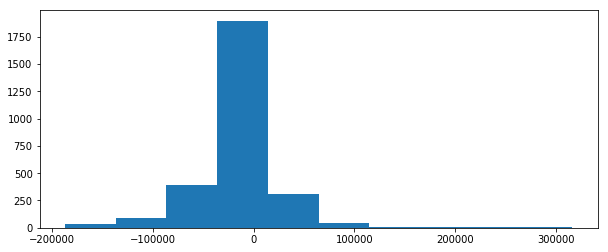

In [23]:
plt.figure(figsize=(10,4))
plt.hist(total_views_merged['slope_15_day']);

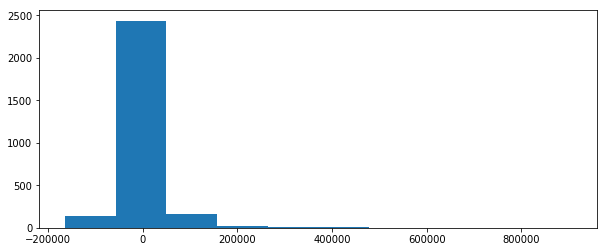

In [24]:
plt.figure(figsize=(10,4))
plt.hist(total_views_merged['slope_7_day']);

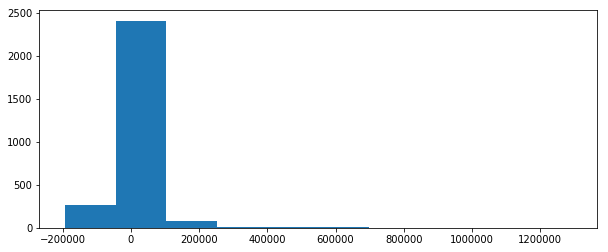

In [25]:
plt.figure(figsize=(10,4))
plt.hist(total_views_merged['slope_5_day']);

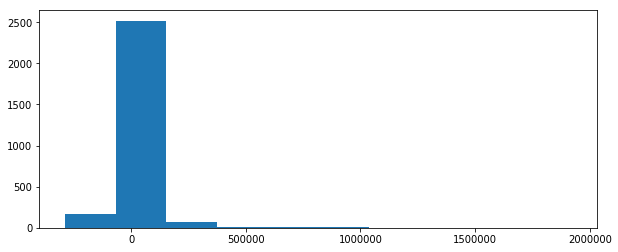

In [26]:
plt.figure(figsize=(10,4))
plt.hist(total_views_merged['slope_3_day']);

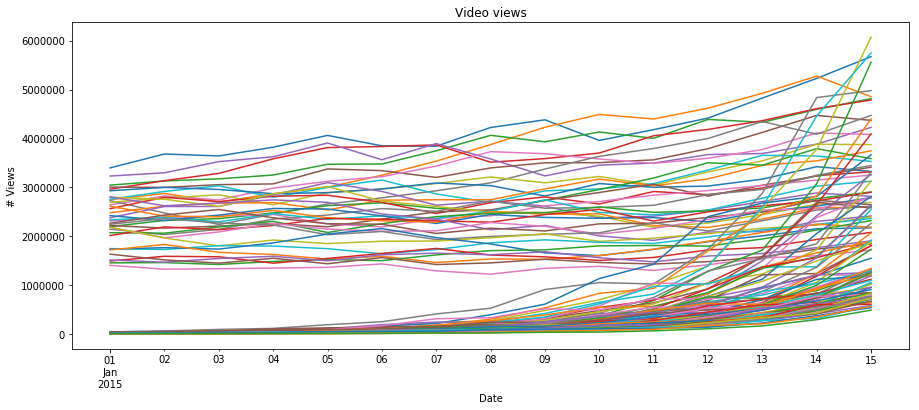

In [27]:
slope_threshold = 100000
plot_video_trends(list(total_views_merged[total_views_merged['slope_5_day']>slope_threshold].index.values), legend=False)

len(total_views_merged[total_views_merged['slope_5_day']>slope_threshold])

I used ordinary least squares to calculate the best fit slope. After some playing around with different lengths of time, I decided to use a 5 day window as the basis of calculating view rate. With a view rate threshold of 100,000 views/day (for the last 5 days), the following chart shows 113 videos.

There is a clear distinction between two groups in this chart.
* Videos that started with nearly zero views but have grown rapidly over the 15- day window.
* Videos that were already popular at the start of the 15-day window, but are still growing in viewership. I have decided to omit these videos from viral video classification as they already have high viewership and popularity.

In [29]:
#15 day threshold = 200000 --> 7 videos
#7 day threshold = 255000 --> 25 videos
#5 day threshold = 300000 --> 28 videos
#3 day threshold = 430000 --> 22 videos 

## Get percentage increase over 15 day period

There are a number of ways that I could’ve filtered out videos from the “already popular” category. I decided to use percentage increase in viewership over the 15-day period in order to distinguish between the groups. Any videos that didn't at least double average daily viewership after two weeks were excluded.

In [30]:
def percent_increase(vid_id, start_day=0):
    end_val = counts[counts.video_id==vid_id]['count'].values[-3:].mean()
    start_val = counts[counts.video_id==vid_id]['count'].values[start_day:start_day+3].mean()
    return (end_val/start_val)-1

In [31]:
#Add percent increase column
video_increases = []
for v_id in total_views_merged.index.values:
    video_increases.append(percent_increase(v_id))
    
total_views_merged['percent_increase'] = video_increases

In [32]:
total_views_merged['percent_increase'].describe()

count    2785.000000
mean       10.921969
std        29.944698
min        -0.950868
25%        -0.771817
50%        -0.125850
75%         0.177515
max       232.933619
Name: percent_increase, dtype: float64

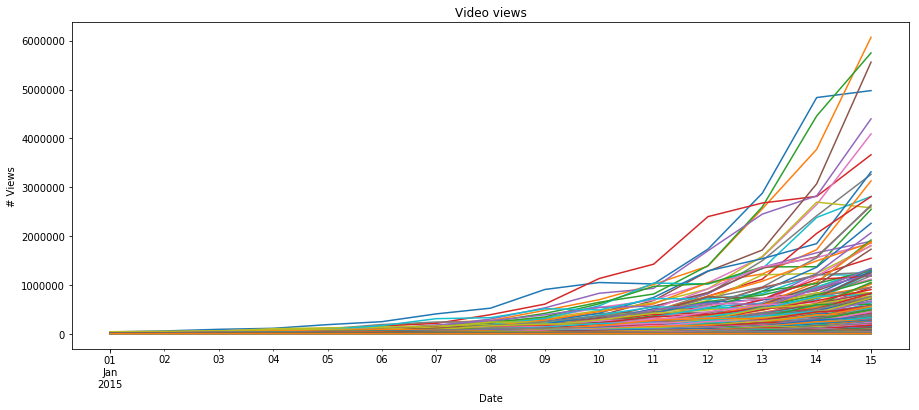

In [33]:
threshold = 1
plot_video_trends(list(total_views_merged[total_views_merged['percent_increase']>threshold].index.values), legend=False)

In [34]:
len(total_views_merged[total_views_merged['percent_increase']>threshold])

492

# COMBINE

The viral video selection using the following filters is a collection of 76 videos which have an upward trend and began from relative obscurity.
* 5-day growth rate > 100,000views/day
* 15-day increase in average daily viewership > 100% (i.e. at least doubled)

The rule-of-thumb regarding viral videos from Facebook data is that approximately 1% of videos have some degree of viral success. The selection made using the filters above represent 2.7% of the videos in the dataset. Using the rule-of- thumb as a guide, perhaps I am not being stringent enough on selection criteria.

* Adjusting the 5-day growth rate threshold to **250,000views/day** leaves only the most rapidly growing videos from the set. These also represent 1% of the videos in the dataset.

In [67]:
percent_increase = 1
slope_threshold = 250000

viral_vids_df = total_views_merged[(total_views_merged['percent_increase']>percent_increase) & 
                                   (total_views_merged['slope_5_day']>slope_threshold) &
                                   (total_views_merged['count']>1000000)]
len(viral_vids_df)

28

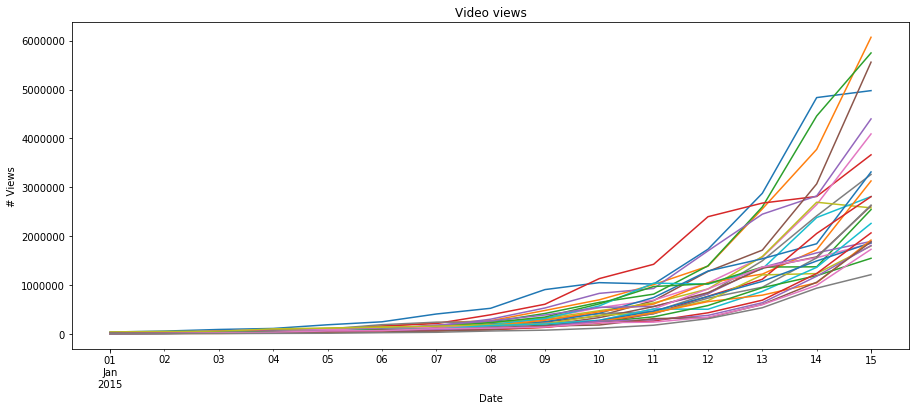

In [68]:
plot_video_trends(list(viral_vids_df.index.values),legend=False)

English Language Viral Videos

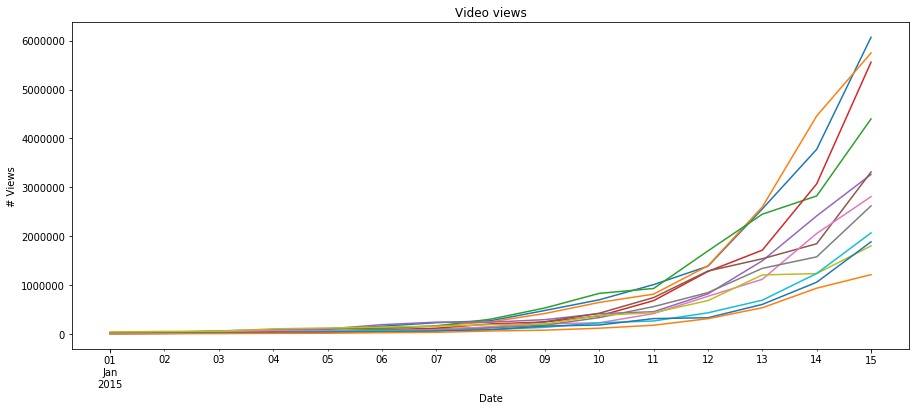

In [69]:
plot_video_trends(list(viral_vids_df[viral_vids_df.video_language=='En'].index.values),legend=False)

## Limitations

This is an unsupervised classification problem. If there was a training data subset containing target labels, then a classifier could look at the other features which distinguish a viral video. 

Viral video viewership rate and percentage increase are assumptions made based on the plotted data. Labeled training data would allow for analysis and direct comparison to known viral videos for verification (or adjustment) of thresholds.

The definition of a viral video is somewhat subjective. Some sources say that > 5M views in a 5-7 day period qualify a video as viral. It would be useful to define our own classification criteria based on impact to bounce rate.

## Further work
While not analyzed here, language, video length and video quality will likely have an impact on bounce rate. Additional analysis using these features could prove to be interesting.

Additionally, there are about 100 videos that are trending upwards that have not reached the rate threshold. Some of these videos are not yet viral but have high potential if the trend continues. If a majority of these videos end up going viral, perhaps adjustment of the thresholds could be used for early detection.

In [43]:
viral_vids_df.head()

,video_length,video_language,video_upload_date,video_quality,count,slope_15_day,slope_7_day,slope_5_day,slope_3_day,percent_increase
video_id,,,,,,,,,,
136,577,Cn,2014-12-16,720p,19068523,315248.435714,773059.678571,1101910.3,1050317.5,66.596129
2540,155,En,2014-12-15,1080p,16856675,310522.007143,874240.428571,1251342.3,1756052.0,180.995995
144,760,En,2014-12-22,1080p,16782672,316225.635714,907500.714286,1293713.6,1575023.0,164.248987
2099,979,Cn,2014-12-18,480p,15728759,253770.442857,492387.428571,489419.7,493687.0,97.839987
2794,110,En,2014-12-17,1080p,14563583,249954.582143,611240.678571,806340.7,974799.0,76.723666
